### This notebook generates the SD-CAPE relationships for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index
from zero_buoyancy_plume import zero_buoyancy_plume_plev
from scipy.optimize import minimize

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air
Lv = 2260*10**3 # J/kg
threshold = 10

In [27]:
# array of years
#years = np.arange( 1983, 2008 )
years = np.arange( 2000, 2003 )

# create list of file names
#file_years = file_concatenator_ERA(years)
file_years = file_concatenator_ERA5(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_rain_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) )[:,0] #& (pmax_array >= np.percentile(pmax_array,75))
#print(tropical_indx.shape)
print(tropical_rain_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERA = negative_to_nan(lifetime_array)[tropical_rain_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERA = negative_to_nan(rad_array)[tropical_rain_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERA = negative_to_nan(maxrad_array)[tropical_rain_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERA = negative_to_nan(minctt_array)[tropical_rain_indx]

-33.0
27.0
(103209,)


In [28]:
# creating cape array from different files and treating for negatives
cape_array = nc_open_compile(file_years,"cape_mean") # SS_20250204 "cape" -> "cape_mean"
cape_ERA = negative_to_nan(cape_array)[tropical_rain_indx]
cape_array = nc_open_compile(file_years,"cape_99") # SS_20250204 "cape" -> "cape_mean"
cape99_ERA = negative_to_nan(cape_array)[tropical_rain_indx]
#capepre_array = nc_open_compile(file_years,"capepre")
#capepre_ERA = negative_to_nan(capepre_array)[tropical_indx]
#capepre6_array = nc_open_compile(file_years,"capepre6")
#capepre6_ERA = negative_to_nan(capepre6_array)[tropical_rain_indx]
#capepre9_array = nc_open_compile(file_years,"capepre9")
#capepre9_ERA = negative_to_nan(capepre9_array)[tropical_indx]

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv_mean", 'stack' ) # SS_20250204 "qv" -> "qv_mean"
qv_ERA = negative_to_nan(qv_array)[tropical_rain_indx]
#qvpre_array = nc_open_compile( file_years, "qvpre", 'stack' )
#qvpre_ERA = negative_to_nan(qvpre_array)[tropical_rain_indx]
#qvpre6_array = nc_open_compile( file_years, "qvpre6", 'stack' )
#qvpre6_ERA = negative_to_nan(qvpre6_array)[tropical_rain_indx]
#qvpre9_array = nc_open_compile( file_years, "qvpre9", 'stack' )
#qvpre9_ERA = negative_to_nan(qvpre9_array)[tropical_rain_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERA = np.double((xr.open_dataset(file_years[0])).pressure_level.data)*100 # SS_20250204 "pressure" -> "pressure_level"

In [29]:
# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERA = nc_open_compile( file_years, "temperature_mean", 'stack' )[tropical_rain_indx] # SS_20250204 "temperature" -> "temperature_mean"
qvsat_ERA = eps * satVapP_liq(temp_ERA) / ( plev_ERA - satVapP_liq(temp_ERA) )

# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
i = np.argmin( np.abs(plev_ERA - 85000) )
sd850_ERA = (qvsat_ERA[:,i] - qv_ERA[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
#sd850pre_ERA = (qvsat_ERA[:,i] - qvpre6_ERA[:,i])*1000
i = np.argmin( np.abs(plev_ERA - 70000) )
sd700_ERA = (qvsat_ERA[:,i] - qv_ERA[:,i])*1000
#sd700pre_ERA = (qvsat_ERA[:,i] - qvpre6_ERA[:,i])*100
i = np.argmin( np.abs(plev_ERA - 55000) )
sd550_ERA = (qvsat_ERA[:,i] - qv_ERA[:,i])*1000
#sd550pre_ERA = (qvsat_ERA[:,i] - qvpre6_ERA[:,i])*1000

sd_ERA = (sd850_ERA + sd700_ERA + sd550_ERA)/3
#sdpre_ERA = (sd850pre_ERA + sd700pre_ERA + sd550pre_ERA)/3
print( 'Min, Mean, and Max SD [g kg-1]: ' + str(np.nanmin(sd_ERA)) + ' ' + str(np.nanmedian(sd_ERA)) + ' ' + str(np.nanmax(sd_ERA)) )

Min, Mean, and Max SD [g kg-1]: -0.9855705447486827 1.9420557099677802 10.66084041916753


### What does the probability distribution of saturation deficits look like?

[1.33333333 1.66666667 2.         2.33333333 2.66666667 3.
 3.33333333 3.66666667]
[15.28839539 15.83582827 13.91739093 10.78297435  7.43733589  4.80384463
  3.08984682  2.03567518]
73.19129145713694


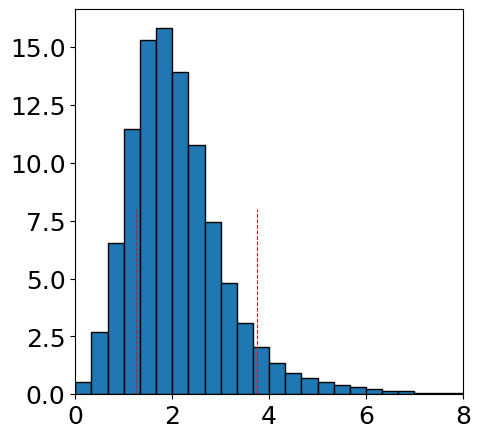

In [30]:
fig = plt.figure( figsize=(5,5) )
wgts = np.ones_like( sd_ERA )/float(len(sd_ERA))*100.
h, edges = np.histogram( sd_ERA, bins=np.linspace(0,8,25), weights=wgts )
print(edges[4:12]) # 4:12 represent bins for SD = 1.25-3.75 g kg-1
print(h[4:12])
print(np.cumsum(h[4:12])[-1])
plt.hist( sd_ERA, bins=np.linspace(0,8,25), weights=wgts, edgecolor='k' )
plt.plot( [1.25, 1.25], [0, 8], lw=0.75, ls='--', color='red' )
plt.plot( [3.75, 3.75], [0, 8], lw=0.75, ls='--', color='red' )
plt.xlim( [0,8] )
plt.show()

[ 3.98239588 14.33116047 28.25637222 42.43042273 55.89308716 67.45677037
 76.51254928 83.38245053 88.25969007 91.81076545 94.31574222 96.10055037
 97.36328506 98.22982942 98.77044381 99.16077911 99.42718295 99.6096647
 99.72969281 99.8214216  99.87118935 99.91217456 99.93949803 99.96291815]
[  10.          134.58333333  259.16666667  383.75        508.33333333
  632.91666667  757.5         882.08333333 1006.66666667 1131.25
 1255.83333333 1380.41666667 1505.         1629.58333333 1754.16666667
 1878.75       2003.33333333 2127.91666667 2252.5        2377.08333333
 2501.66666667 2626.25       2750.83333333 2875.41666667 3000.        ]


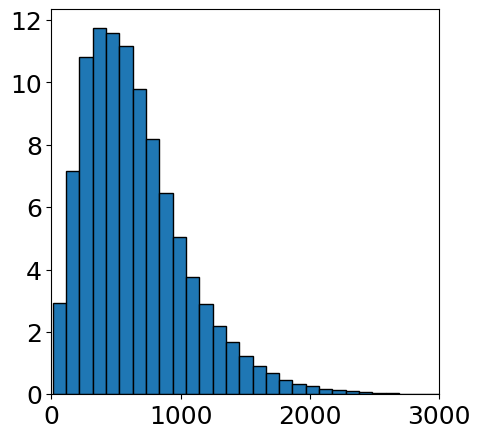

In [31]:
fig = plt.figure( figsize=(5,5) )
i = np.argwhere( cape_ERA > 10 )
wgts = np.ones_like( cape_ERA[i[:,0]] )/float(len(cape_ERA[i[:,0]]))*100.
h, edges = np.histogram( cape_ERA[i[:,0]], bins=np.linspace(10,3000,25), weights=wgts )
cumulative_counts = np.cumsum(h)
print(cumulative_counts)
print(edges)
plt.hist( cape_ERA[i[:,0]], bins=np.linspace(10,3000,30), weights=wgts, edgecolor='k' )
plt.xlim( [0,3000] )
plt.show()

In [32]:
pc2 = 99
nbin = 30
sdupper = 5

# create bins for *positive* saturation deficits and evaluate corresponding CAPE percentiles
sd_bins, cape_vals, cape_95_vals, cape_99_vals, sd_error, cape_error, sd_max, cape_max = \
    bin_stat_function( nbin, 0, sdupper, sd_ERA, cape_ERA, pc2=pc2, threshold=threshold )

sd_bins, cape_99_vals, cape_95_vals, _, sd_error, cape_error, sd_max, cape_max = \
    bin_stat_function( nbin, 0, sdupper, sd_ERA, cape99_ERA, pc2=pc2, threshold=threshold )

In [33]:
# create bins in SD and evaluate corresponding CAPE percentiles for longest-lived systems
upp = np.percentile( lifetime_ERA, 75 )
loo = np.percentile( lifetime_ERA, 25 )
sd_bins_old, cape_vals_old, _, cape_99_vals_old, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERA[lifetime_ERA >= upp], cape_ERA[lifetime_ERA >= upp], pc2=pc2, threshold=threshold )

# create bins in SD and evaluate corresponding CAPE percentiles for shortest-lived systems
sd_bins_young, cape_vals_young, _, cape_99_vals_young, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERA[lifetime_ERA <= loo], cape_ERA[lifetime_ERA <= loo], pc2=pc2, threshold=threshold )

# create bins in SD and evaluate corresponding CAPE percentiles for smallest systems
upp = np.percentile( rad_ERA, 75 )
loo = np.percentile( rad_ERA, 25 )
sd_bins_small, cape_vals_small, _, cape_99_vals_small, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERA[rad_ERA <= loo], cape_ERA[rad_ERA <= loo], pc2=pc2, threshold=threshold )

# create bins in SD and evaluate corresponding CAPE percentiles for largest systems
sd_bins_large, cape_vals_large, _, cape_99_vals_large, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERA[rad_ERA >= upp], cape_ERA[rad_ERA >= upp], pc2=pc2, threshold=threshold )

# create bins in SD and evaluate corresponding CAPE percentiles for deepest systems
upp = np.percentile( minctt_ERA, 75 )
loo = np.percentile( minctt_ERA, 25 )
sd_bins_deep, cape_vals_deep, _, cape_99_vals_deep, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERA[minctt_ERA <= loo], cape_ERA[minctt_ERA <= loo], pc2=pc2, threshold=threshold )

# create bins in SD and evaluate corresponding CAPE percentiles for shallowest systems
sd_bins_shallow, cape_vals_shallow, _, cape_99_vals_shallow, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERA[minctt_ERA >= upp], cape_ERA[minctt_ERA >= upp], pc2=pc2, threshold=threshold )

In [34]:
#sdpre_bins, cape_vals2, _, cape_99_vals2, _, _, _, _ = \
#    bin_stat_function( nbin, 0, sdupper, sdpre_ERA, cape_ERA, pc2=pc2, threshold=100 )

#sd_bins2, capepre_vals, _, capepre_99_vals, _, _, _, _ = \
#    bin_stat_function( nbin, 0, sdupper, sd_ERA, capepre6_ERA, pc2=pc2, threshold=100 )

#sdpre_bins2, capepre_vals2, _, capepre_99_vals2, _, _, _, _ = \
#    bin_stat_function( nbin, 0, sdupper, sdpre_ERA, capepre6_ERA, pc2=pc2, threshold=100 )

### Binning of CAPE and saturation deficit across percentiles

In [41]:
valid_mask = ~np.isnan( sd_bins) & ~np.isnan( cape_99_vals )
sd_bins_nonan = sd_bins[valid_mask]
cape_99_vals_nonan = cape_99_vals[valid_mask]
m, b, r_value, p_value, _ = stats.linregress( sd_bins_nonan[:15], cape_99_vals_nonan[:15] ) # ZBP behavior up to SD ~ 2.5 g kg-1
print( m, b, r_value**2, p_value )

603.808830436701 282.79736381743066 0.9855697179728503 2.369432626625054e-13


In [67]:
# calculate the zero-buoyancy plume CAPE value for a given collocation, minimize epsilon
epsilon_range = np.logspace( -5, -3.3, 30 )

def CAPEdiff( epsilon ):
    CAPE_zbp = np.empty( temp_ERA.shape[0] )
    for i in np.arange( temp_ERA.shape[0] ):
        CAPE_zbp[i], _ = zero_buoyancy_plume_plev( temp_ERA[i,:15], qv_ERA[i,:15], plev_ERA[:15], epsilon=epsilon )  # SS 20250208 removed [,13:] from all

    sd_bins_zbp, cape_vals_zbp, _, cape_99_vals_zbp, _, _, _, _ = \
        bin_stat_function( nbin, 0, sdupper, sd_ERA, CAPE_zbp, pc2=pc2, threshold=threshold )
    
    # using indices 7-17 here because that is where the tracking data roughly correlates positively
    #print( cape_99_vals_zbp )
    return np.nansum( (cape_99_vals_zbp[7:17] - cape_99_vals[7:17])**2 )  # SS 20250208 removed [7:17] --> [:17]

In [68]:
def tune_entrainment( epsilon_range ):
    results = []
    for epsilon in epsilon_range:
        print( epsilon )
        result = CAPEdiff( epsilon )
        results.append( (epsilon, result) )
    return results

results = tune_entrainment( epsilon_range )
min_result = min( results, key=lambda x: x[1] )
print(f"Optimal epsilon: {min_result[0]} with error: {min_result[1]}")

1e-05
1.1445128937012381e-05
1.3099097638483817e-05
1.4992086143096169e-05
1.7158635894253233e-05
1.9638280019297697e-05
2.2476264692201618e-05
2.572437474246664e-05
2.944187857515554e-05
3.369660964405176e-05
3.856620421163472e-05
4.4139517981330935e-05
5.051824745139091e-05
5.78187855753066e-05
6.617434558908557e-05
7.573739175895009e-05
8.668242140342028e-05
9.920914895345869e-05
0.00011354615015036016
0.00012995503287722399
0.00014873521072935117
0.00017022936642711317
0.0001948297047624237
0.00022298510917659944
0.00025520933255599636
0.000292090371703225
0.0003343011965403283
0.0003826120298201575
0.0004379044014143729
0.0005011872336272725
Optimal epsilon: 1.9638280019297697e-05 with error: 68250.48189541814


In [59]:
#del CAPE_zbp
epsilon = min_result[0]
CAPE_zbp = np.empty( temp_ERA.shape[0] )
for i in np.arange( temp_ERA.shape[0] ):
    CAPE_zbp[i], _ = zero_buoyancy_plume_plev( temp_ERA[i], qv_ERA[i], plev_ERA, epsilon=epsilon )
 
sd_bins_zbp, cape_vals_zbp, _, cape_99_vals_zbp, _, _, _, _ = \
    bin_stat_function( nbin, 0, sdupper, sd_ERA, CAPE_zbp, pc2=pc2, threshold=threshold )

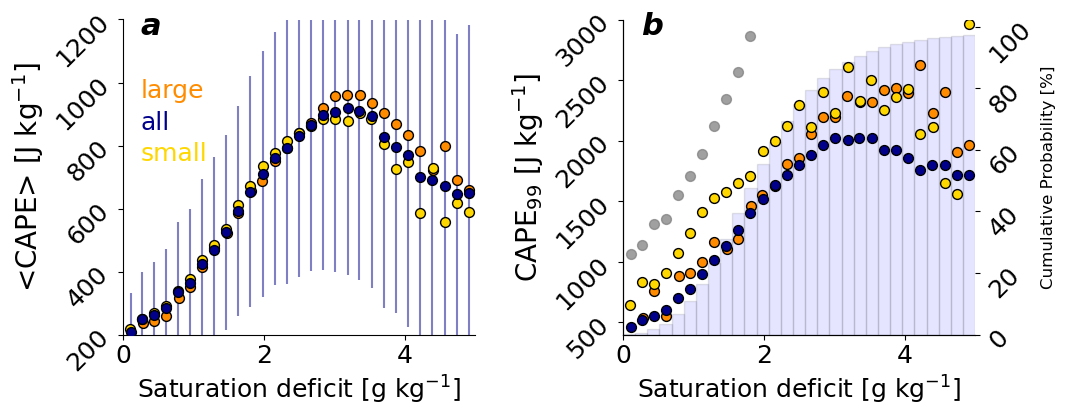

In [60]:
fig, ax = plt.subplots( 1, 2, figsize =(11, 4.5) )

ylab = [ r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]', r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]',
         r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]']
labels = [ '', '',  r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]' ]
let = [ 'a', 'b' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})

for i, axis in enumerate(ax.flat): 
    axis.set( ylabel = ylab[i] )
    axis.set_xlim( [0, 5] )
    axis.spines['top'].set_visible( False )
    axis.spines['right'].set_visible( False )
    axis.set( xlabel = labels[i] )
    #axis.get_xticks().set_rotation(45)
    for t in axis.get_yticklabels():
        t.set_rotation(45)
    axis.text( 0.05, 0.95, let[i], transform=axis.transAxes, fontsize=font_size+4, weight='bold', style='italic' )
    
    aaa=0.6
    if i == 0:
        axis.errorbar( sd_bins, cape_vals, xerr=sd_error/2, yerr=cape_error/2, color = 'darkblue', ls='none', zorder=0, 
                     alpha=0.5 )
        axis.scatter( sd_bins_large, cape_vals_large, s=50, color='darkorange', edgecolor='k' )
        axis.scatter( sd_bins_small, cape_vals_small, s=50, color='gold', edgecolor='k' )
        #axis.scatter( sd_bins_deep, cape_vals_deep, s=50, color='turquoise', edgecolor='k' )
        #axis.scatter( sd_bins_shallow, cape_vals_shallow, s=50, color='green', edgecolor='k' )
        axis.scatter( sd_bins, cape_vals, s=50, color='darkblue', edgecolor='k', zorder=10 )
        axis.text( 0.05, 0.55, 'small', transform=axis.transAxes, color='gold', fontsize=18 )
        axis.text( 0.05, 0.65, r'all', transform=axis.transAxes, color='darkblue', fontsize=18 )
        axis.text( 0.05, 0.75, r'large', transform=axis.transAxes, color='darkorange', fontsize=18 )
        axis.set_ylim([200, 1200])
        axis.set_xlabel( r'Saturation deficit [g kg$^{-1}$]', fontsize=font_size )
    elif i == 1:
        wgts = np.ones_like( sd_ERA )/float(len(sd_ERA))*100.
        axis2 = axis.twinx()
        axis.set_zorder(10)
        axis.patch.set_visible(False)
        h = axis2.hist( sd_ERA, bins=np.linspace(0, sdupper, nbin), cumulative=True, weights=wgts, alpha=0.1, edgecolor='k', color='blue' )
        #print(h)
        axis2.spines['top'].set_visible( False )
        axis2.spines['right'].set_visible( False )
        axis2.set_axisbelow( True )
        axis2.set_ylabel( 'Cumulative Probability [%]', fontsize=12 )
        for t in axis2.get_yticklabels():
            t.set_rotation(45)
        
        axis.scatter( sd_bins_large, cape_99_vals_large, s=50, color='darkorange', edgecolor='k' )
        axis.scatter( sd_bins_small, cape_99_vals_small, s=50, color='gold', edgecolor='k' )
        axis.scatter( sd_bins, cape_99_vals, s=50, color='darkblue', edgecolor='k', zorder=10 )
        axis.scatter( sd_bins_zbp, cape_99_vals_zbp, s=50, alpha=0.75, color='gray' )
        #axis.scatter( sd_bins_nonan, m*sd_bins_nonan + b, s=50, alpha=0.75, color='gray' )#, edgecolor='k' )
        axis.set_ylim([400, 3000])
        axis.set_xlabel( r'Saturation deficit [g kg$^{-1}$]', fontsize=font_size )

plt.tight_layout()
#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/sd-cape-ERA-percentiles.pdf', bbox_inches='tight' )
plt.show()

In [11]:
# What are the slopes of linear regressions of SDpre-CAPE, SD-CAPEpre, etc.?
i = np.argwhere( (~np.isnan(sdpre_bins)) & (~np.isnan(cape_vals2)) )
out = scipy.stats.linregress( x=sdpre_bins[i[:,0]], y=cape_vals2[i[:,0]] )
print(out)
print(out.slope)

i = np.argwhere( (~np.isnan(sd_bins)) & (~np.isnan(cape_vals)) )
out = scipy.stats.linregress( x=sd_bins[i[:,0]], y=cape_vals[i[:,0]] )
print(out)

LinregressResult(slope=-118.6177255402313, intercept=693.2737389445159, rvalue=-0.9250359289479381, pvalue=5.25950545052445e-12, stderr=9.742423140621572, intercept_stderr=26.153430461562984)
-118.6177255402313
LinregressResult(slope=-37.4433026969187, intercept=622.0353844513018, rvalue=-0.7836229837040093, pvalue=4.978423360367831e-07, stderr=5.712710226103314, intercept_stderr=16.481890374766447)


In [12]:
# What are the slopes of linear regressions of SD-CAPE99 for the range of ZBP behavior?
sd_zbp = sd_bins[5:17]
cape99_zbp = cape_99_vals[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out)
print("Inferred entrainment: " + str(out.slope/Lv))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

sd_zbp = sd_bins_small[5:17]
cape99_zbp = cape_99_vals_small[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_large[5:17]
cape99_zbp = cape_99_vals_large[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_old[5:17]
cape99_zbp = cape_99_vals_old[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_young[5:17]
cape99_zbp = cape_99_vals_young[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_shallow[5:17]
cape99_zbp = cape_99_vals_shallow[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

sd_zbp = sd_bins_deep[5:17]
cape99_zbp = cape_99_vals_deep[5:17]
i = np.argwhere( (~np.isnan(sd_zbp)) & (~np.isnan(cape99_zbp)) )
out = scipy.stats.linregress( x=sd_zbp[i[:,0]], y=cape99_zbp[i[:,0]] )
print(out.slope)

LinregressResult(slope=104.46592234778987, intercept=1866.9863409378088, rvalue=0.5915051788501406, pvalue=0.04278316953651112, stderr=45.031187244418724, intercept_stderr=89.50522004518513)
Inferred entrainment: 4.2473453501722615e-06
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
80.15514685803183
139.9610345188932
198.06756712765537
27.7342180525851
61.32208671164534
183.5910000324333


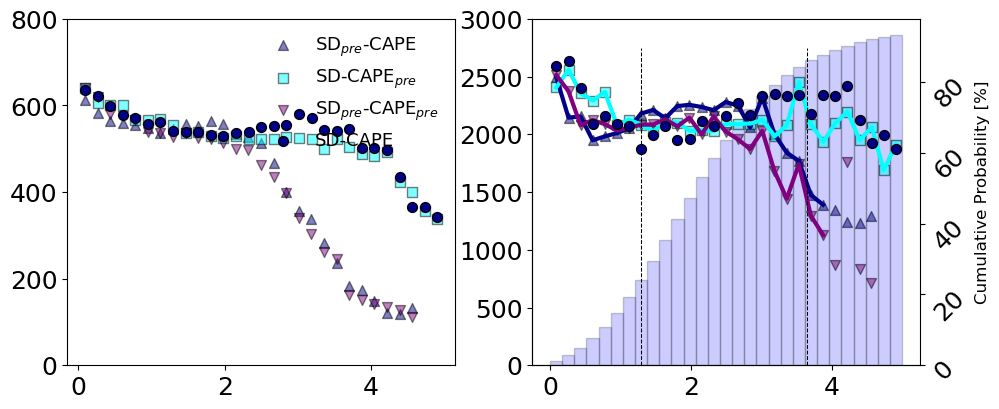

In [23]:
fig, ax = plt.subplots( 1, 2, figsize =(11, 4.5) )

ylab = [ r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]', r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]',
         r'<CAPE> [J kg$^{-1}$]', r'CAPE$_{99}$ [J kg$^{-1}$]']
labels = [ '', '',  r'Saturation Deficit [g kg$^{-1}$]', r'Saturation Deficit [g kg$^{-1}$]' ]
let = [ 'a', 'b' ]
font_size = 18
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
aaa=0.5

for i, axis in enumerate(ax.flat): 
    if i == 0:
        axis.scatter( sdpre_bins, cape_vals2, s=50, marker='^', color='darkblue', alpha=aaa, edgecolor='k',
                        label=r'SD$_{pre}$-CAPE')
        axis.scatter( sd_bins, capepre_vals, s=50, marker='s', color='cyan', alpha=aaa, edgecolor='k',
                        label=r'SD-CAPE$_{pre}$')
        axis.scatter( sdpre_bins2, capepre_vals2, s=50, marker='v', color='purple', alpha=aaa, edgecolor='k',
                        label=r'SD$_{pre}$-CAPE$_{pre}$')
        axis.scatter( sd_bins, cape_vals, s=50, color='darkblue', edgecolor='k', label='SD-CAPE' )
        axis.legend( frameon=False, fontsize=13, loc='upper right' )
        axis.set_ylim([0, 800])
    elif i == 1:
        wgts = np.ones_like( sd_ERA )/float(len(sd_ERA))*100.
        axis2 = axis.twinx()
        axis.set_zorder(10)
        axis.patch.set_visible(False)
        axis2.hist( sd_ERA, bins=np.linspace(0, sdupper, nbin), cumulative=True, weights=wgts, alpha=0.2, edgecolor='k', color='blue' )
        axis2.spines['top'].set_visible( False )
        axis2.spines['right'].set_visible( False )
        axis2.set_axisbelow( True )
        axis2.set_ylabel( 'Cumulative Probability [%]', fontsize=12 )
        for t in axis2.get_yticklabels():
            t.set_rotation(45)
        
        axis.scatter( sdpre_bins, cape_99_vals2, s=50, marker='^', color='darkblue', alpha=aaa, edgecolor='k' )
        axis.plot( sdpre_bins[0:-7], cape_99_vals2[0:-7], color='darkblue', lw=3 )
        axis.scatter( sd_bins, capepre_99_vals, s=50, marker='s', color='cyan', alpha=aaa, edgecolor='k' )
        axis.plot( sd_bins, capepre_99_vals, color='cyan', lw=3 )
        axis.scatter( sdpre_bins2, capepre_99_vals2, s=50, marker='v', color='purple', alpha=aaa, edgecolor='k' )
        axis.plot( sdpre_bins2[:-7], capepre_99_vals2[:-7], color='purple', lw=3 )
        axis.plot( [1.2977, 1.2977], [0, 2750], color='k', lw=0.75, ls='--' )
        axis.plot( [3.645, 3.645], [0, 2750], color='k', lw=0.75, ls='--' )
        axis.scatter( sd_bins, cape_99_vals, s=50, color='darkblue', edgecolor='k', zorder=10 )
        axis.set_ylim([0, 3000])